In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
import torch
import torch.nn as nn
import os
import sys
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
from IPython import display

from opticaltomography.forward_inner import PhaseObject3D, Multislice
from opticaltomography.loss import mse_loss, sparsity_loss, total_variation_loss
from opticaltomography.utils import showimgstack

# Units in microns
wavelength = 0.6  # fluorescence wavelength/um
# objective immersion media
n_measure = 1.33
# background refractive index, PDMS
n_b = 1.33
mag = 80  # Q：magnification's physical meaning?
# pixel_size = 6.5e-6 Q：pixel_size unit? If it is too small?
pixel_size = 6.5
na = 1
dx = pixel_size / mag
dy = dx
dz = pixel_size / mag

dtype = torch.float32
np_dtype = np.float32

# import known input field from matlab file
# fx_illu_list: x position ex. 0.0041
# fy_illu_list: y position ex. -0.0146
# fz_illu_list: z layer    ex. 3
na_list = sio.loadmat("na_list_3D_rand_10.mat")
fx_illu_list = na_list["na_list_3D_rand"][:, 0] * 0.9    #paraxial condition
fy_illu_list = na_list["na_list_3D_rand"][:, 1] * 0.9
fz_illu_list = na_list["na_list_3D_rand"][:, 2] * 0      #z layer at the z=0

# initial object, type: torch.float32
phantom = torch.zeros((200, 200, 25), dtype=dtype)

# ---------------------------#
# Setup solver objects
# ---------------------------#
solver_params = dict(wavelength = wavelength, na = na, \
                     RI_measure = n_measure, sigma = 2 * np.pi * dz / wavelength,\
                     fx_illu_list = fx_illu_list, fy_illu_list = fy_illu_list, fz_illu_list = fz_illu_list, \
                     voxel_size=(dy,dx,dz), pad = False, pad_size=(50,50))
phase_obj_3d = PhaseObject3D(shape=phantom.shape, voxel_size=(dy,dx,dz), RI=n_b)
solver_obj = Multislice(phase_obj_3d=phase_obj_3d, **solver_params)
solver_obj.setScatteringMethod(model="MultiPhaseContrast")  # solver.obj._x set to zero

# ---------------------------#
# Fill in phantom
# ---------------------------#
# import the ground truth of the 3D object to generate forward measurements
phantom_coordinates = sio.loadmat("phantomPoisson_nooverlap.mat")
phantom_temp = phantom_coordinates["phantomPoisson"]
solver_obj._x[50:150, 50:150, :] = torch.from_numpy(phantom_temp) * 0.1
np.save('Data/ground_truth_na_list_3D_rand_10',solver_obj._x)
"""
solver_obj._x[0:100, 0:100, :] = torch.from_numpy(phantom_temp) * 0.1
solver_obj._x[100:200, 100:200, :] = torch.from_numpy(phantom_temp) * 0.1
solver_obj._x[0:100, 100:200, :] = torch.from_numpy(phantom_temp) * 0.1
solver_obj._x[100:200, 0:100, :] = torch.from_numpy(phantom_temp) * 0.1
solver_obj._x[0:100, 200:300, :] = torch.from_numpy(phantom_temp) * 0.1
solver_obj._x[100:200, 200:300, :] = torch.from_numpy(phantom_temp) * 0.1
solver_obj._x[200:300, 0:100, :] = torch.from_numpy(phantom_temp) * 0.1
solver_obj._x[200:300, 200:300, :] = torch.from_numpy(phantom_temp) * 0.1
solver_obj._x[200:300, 100:200, :] = torch.from_numpy(phantom_temp) * 0.1
"""

'\nsolver_obj._x[0:100, 0:100, :] = torch.from_numpy(phantom_temp) * 0.1\nsolver_obj._x[100:200, 100:200, :] = torch.from_numpy(phantom_temp) * 0.1\nsolver_obj._x[0:100, 100:200, :] = torch.from_numpy(phantom_temp) * 0.1\nsolver_obj._x[100:200, 0:100, :] = torch.from_numpy(phantom_temp) * 0.1\nsolver_obj._x[0:100, 200:300, :] = torch.from_numpy(phantom_temp) * 0.1\nsolver_obj._x[100:200, 200:300, :] = torch.from_numpy(phantom_temp) * 0.1\nsolver_obj._x[200:300, 0:100, :] = torch.from_numpy(phantom_temp) * 0.1\nsolver_obj._x[200:300, 200:300, :] = torch.from_numpy(phantom_temp) * 0.1\nsolver_obj._x[200:300, 100:200, :] = torch.from_numpy(phantom_temp) * 0.1\n'

interactive(children=(IntSlider(value=0, description='i', max=9), Output()), _dom_classes=('widget-interact',)…

<function __main__.updateFrames(i)>

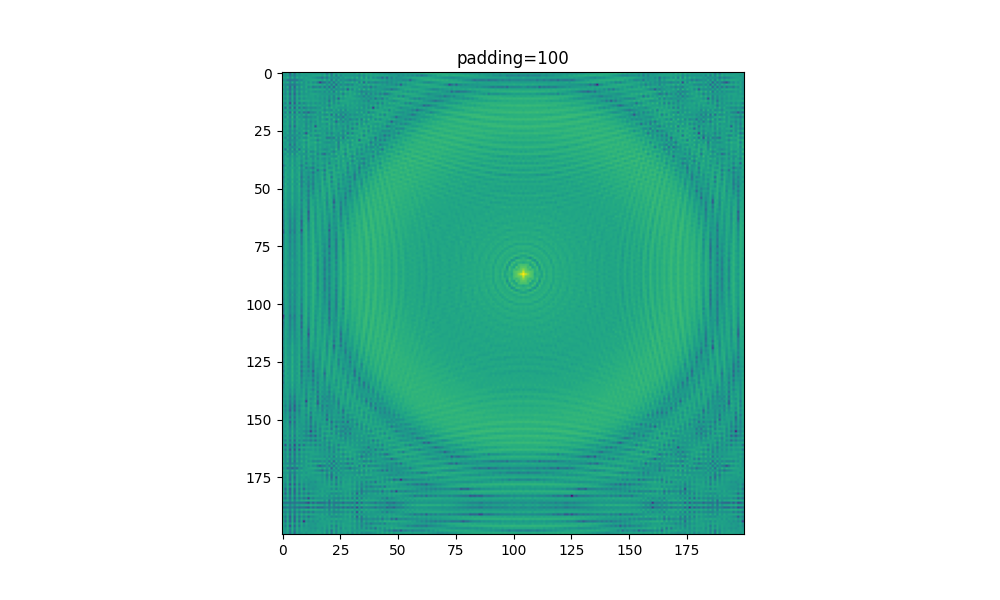

In [5]:
# ---------------------------#
# Generate forward prediction
# ---------------------------#
forward_field_mb, fields = solver_obj.forward(obj=solver_obj._x)

# ---------------------------#
# Show forward prediction
# ---------------------------#
# forward_field_mb[0].shape

# Show forward
f, axes = plt.subplots(1, 1, figsize=(10, 6))
# axes.colorbar()
frames = []

def init():
    img = torch.fft.fftshift(torch.abs(solver_obj.test_prop[0]))
    frames.append(axes.imshow(img))
    # frames.append(axes.imshow(forward_field_mb[0]))
    # frames.append(axes.imshow(torch.fft.fftshift(solver_obj.pupil)))
    axes.set_title('padding=100')

init()

def updateFrames(i):
    img = torch.fft.fftshift(torch.abs(solver_obj.test_prop[i]))
    frames[0].set_data(img)
    # frames.append(axes.imshow(forward_field_mb[i]))
    # frames.append(axes.imshow(torch.fft.fftshift(solver_obj.pupil)))

interact(updateFrames, i=IntSlider(min=0, max=9, step=1, value=0))

IndexError: list index out of range

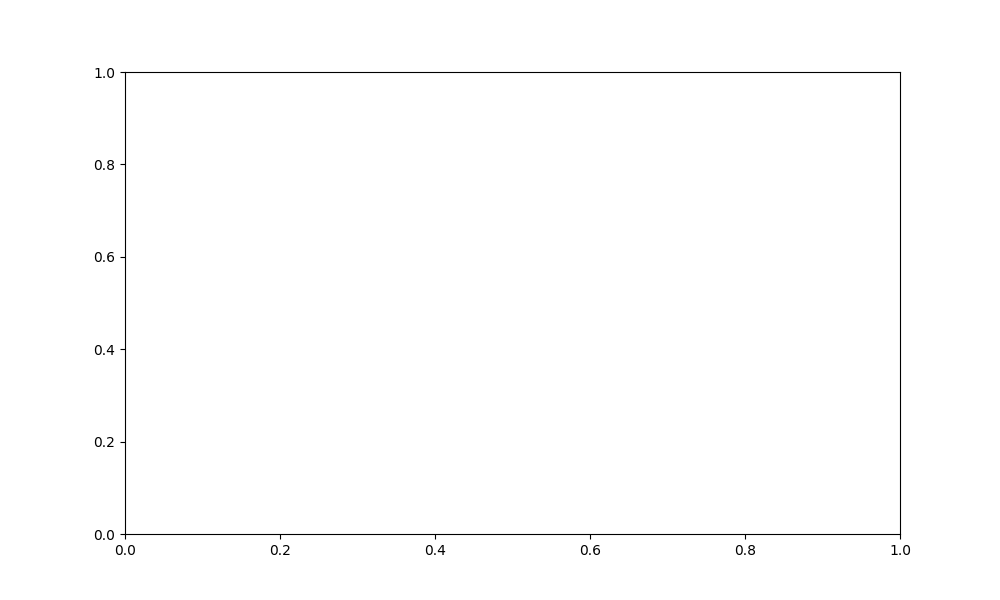

In [3]:
# Show forward
f, axes = plt.subplots(1, 1, figsize=(10, 6))
frames = []

def init():
    img = torch.fft.fftshift(torch.real(solver_obj.test_spherical[0]))
    frames.append(axes.imshow(img))
    # frames.append(axes.imshow(torch.fft.fftshift(solver_obj.pupil)))
    axes.set_title('spherical wave at z = 0 (real)')

init()

def updateFrames(i):
    img = torch.fft.fftshift(torch.real(solver_obj.test_spherical[i]))
    frames[0].set_data(img)
    # frames.append(axes.imshow(torch.fft.fftshift(solver_obj.pupil)))


interact(updateFrames, i=IntSlider(min=0, max=9, step=1, value=0))

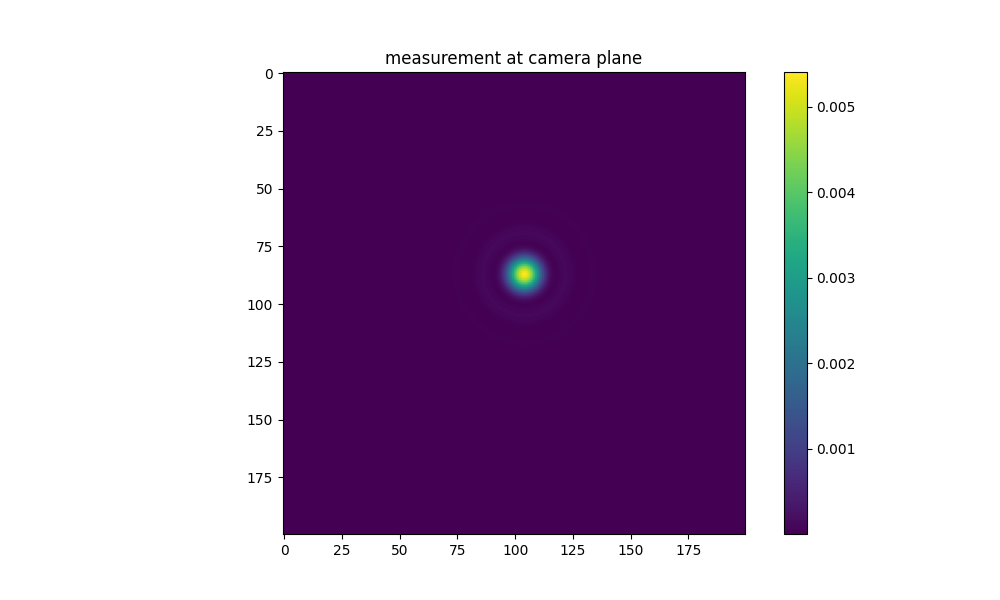

In [32]:
plt.clf()
img = forward_field_mb[0]
plt.imshow(img)
plt.title('measurement at camera plane')
plt.colorbar()
plt.show()

In [3]:
solver_obj.test[0].shape

torch.Size([200, 200])

In [4]:
forward_field_mb[0]

tensor([[0.0198, 0.0027, 0.0164,  ..., 0.0090, 0.0158, 0.0060],
        [0.0023, 0.0041, 0.0025,  ..., 0.0017, 0.0015, 0.0035],
        [0.0224, 0.0003, 0.0235,  ..., 0.0032, 0.0061, 0.0018],
        ...,
        [0.0092, 0.0007, 0.0047,  ..., 0.0026, 0.0108, 0.0033],
        [0.0087, 0.0024, 0.0055,  ..., 0.0063, 0.0056, 0.0067],
        [0.0061, 0.0002, 0.0075,  ..., 0.0046, 0.0095, 0.0053]])

In [30]:
solver_obj.fzlin

tensor([[2.2167, 2.2165, 2.2161,  ..., 2.2154, 2.2161, 2.2165],
        [2.2165, 2.2164, 2.2160,  ..., 2.2153, 2.2160, 2.2164],
        [2.2161, 2.2160, 2.2155,  ..., 2.2148, 2.2155, 2.2160],
        ...,
        [2.2154, 2.2153, 2.2148,  ..., 2.2141, 2.2148, 2.2153],
        [2.2161, 2.2160, 2.2155,  ..., 2.2148, 2.2155, 2.2160],
        [2.2165, 2.2164, 2.2160,  ..., 2.2153, 2.2160, 2.2164]],
       dtype=torch.float64)

In [31]:
solver_obj.fzlin[0]

tensor([2.2167, 2.2165, 2.2161, 2.2154, 2.2144, 2.2131, 2.2116, 2.2097, 2.2076,
        2.2052, 2.2025, 2.1995, 2.1963, 2.1927, 2.1889, 2.1847, 2.1803, 2.1755,
        2.1705, 2.1652, 2.1595, 2.1536, 2.1473, 2.1408, 2.1339, 2.1267, 2.1192,
        2.1114, 2.1032, 2.0948, 2.0859, 2.0768, 2.0673, 2.0574, 2.0472, 2.0367,
        2.0257, 2.0144, 2.0028, 1.9907, 1.9783, 1.9654, 1.9522, 1.9386, 1.9245,
        1.9100, 1.8950, 1.8796, 1.8638, 1.8474, 1.8306, 1.8133, 1.7954, 1.7771,
        1.7582, 1.7387, 1.7186, 1.6979, 1.6766, 1.6547, 1.6321, 1.6087, 1.5846,
        1.5598, 1.5341, 1.5076, 1.4802, 1.4519, 1.4225, 1.3921, 1.3606, 1.3278,
        1.2937, 1.2582, 1.2211, 1.1824, 1.1418, 1.0991, 1.0541, 1.0065, 0.9558,
        0.9017, 0.8433, 0.7797, 0.7097, 0.6309, 0.5395, 0.4278, 0.2713, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

In [32]:
solver_obj.uxx_shifted

tensor([[ 0.0000,  0.0250,  0.0500,  ..., -0.0750, -0.0500, -0.0250],
        [ 0.0000,  0.0250,  0.0500,  ..., -0.0750, -0.0500, -0.0250],
        [ 0.0000,  0.0250,  0.0500,  ..., -0.0750, -0.0500, -0.0250],
        ...,
        [ 0.0000,  0.0250,  0.0500,  ..., -0.0750, -0.0500, -0.0250],
        [ 0.0000,  0.0250,  0.0500,  ..., -0.0750, -0.0500, -0.0250],
        [ 0.0000,  0.0250,  0.0500,  ..., -0.0750, -0.0500, -0.0250]],
       dtype=torch.float64)

In [33]:
solver_obj.uxx

tensor([[-2.5000, -2.4750, -2.4500,  ...,  2.4250,  2.4500,  2.4750],
        [-2.5000, -2.4750, -2.4500,  ...,  2.4250,  2.4500,  2.4750],
        [-2.5000, -2.4750, -2.4500,  ...,  2.4250,  2.4500,  2.4750],
        ...,
        [-2.5000, -2.4750, -2.4500,  ...,  2.4250,  2.4500,  2.4750],
        [-2.5000, -2.4750, -2.4500,  ...,  2.4250,  2.4500,  2.4750],
        [-2.5000, -2.4750, -2.4500,  ...,  2.4250,  2.4500,  2.4750]],
       dtype=torch.float64)